<a href="https://colab.research.google.com/github/jbmmbj/m494/blob/main/FrEIA_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install FrEIA

  Preparing metadata (setup.py) ... done
  Created wheel for FrEIA: filename=FrEIA-0.2-py3-none-any.whl size=42758 sha256=f3a9a8a59be67c6f87474e93f31cfd3ae5f145fcb56e5864813b4ab679198bda
  Stored in directory: /root/.cache/pip/wheels/81/a8/e2/d532a76f72108ac4a340cbe3f86b4f591abfdbd75209a5badb
Successfully built FrEIA


In [ ]:
# standard imports
import torch
import torch.nn as nn
from sklearn.datasets import make_moons

# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm

BATCHSIZE = 100
N_DIM = 2

# we define a subnet for use inside an affine coupling block
# for more detailed information see the full tutorial
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, 512), nn.ReLU(),
                         nn.Linear(512,  dims_out))

# a simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(N_DIM)
for k in range(8):
    inn.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True)

optimizer = torch.optim.Adam(inn.parameters(), lr=0.001)

# a very basic training loop
for i in range(1000):
    optimizer.zero_grad()
    # sample data from the moons distribution
    data, label = make_moons(n_samples=BATCHSIZE, noise=0.05)
    x = torch.Tensor(data)
    # pass to INN and get transformed variable z and log Jacobian determinant
    z, log_jac_det = inn(x)
    # calculate the negative log-likelihood of the model with a standard normal prior
    loss = 0.5*torch.sum(z**2, 1) - log_jac_det
    loss = loss.mean() / N_DIM
    # backpropagate and update the weights
    loss.backward()
    optimizer.step()

# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
z = torch.randn(BATCHSIZE, N_DIM)
samples, _ = inn(z, rev=True)

In [ ]:
from sklearn.datasets import fetch_openml
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [ ]:
import os, time

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import torch
from torchvision import models


#from google.colab import drive
import scipy.optimize.nnls as nnls
from numpy import linalg as la

import cv2

# CUDA flag. Speed-up due to CUDA is mostly noticable for large batches.
cuda = True

torch.cuda.is_available()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
   # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras.optimizers import Adam ,RMSprop
from sklearn.model_selection import train_test_split
from keras import  backend as K
from keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "/content/input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

test.csv
train.csv



In [10]:
# create the training & test sets, skipping the header row with [1:]
train = pd.read_csv("/content/input/train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
test= pd.read_csv("/content/input/test.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
X_train = (train.iloc[:,1:].values).astype('float32') # all pixel values
y_train = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits
X_test = test.values.astype('float32')

In [14]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
y_train

array([1, 0, 1, ..., 7, 6, 9], dtype=int32)

# Data Visualization

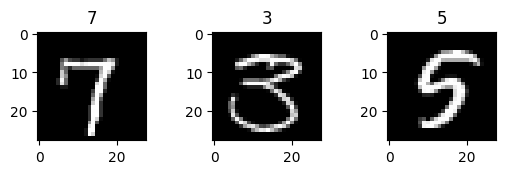

In [16]:
#Convert train datset to (num_images, img_rows, img_cols) format
X_train = X_train.reshape(X_train.shape[0], 28, 28)

for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i]);

In [17]:
#expand 1 more dimention as 1 for colour channel gray
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_train.shape

(42000, 28, 28, 1)

In [18]:
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)
X_test.shape

(28000, 28, 28, 1)

#Preprocessing the digit images

Feature Standardization

In [19]:
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

def standardize(x):
    return (x-mean_px)/std_px

In [24]:
from tensorflow.keras import utils
utils.to_categorical

<function keras.src.utils.np_utils.to_categorical(y, num_classes=None, dtype='float32')>

In [26]:
y_train= utils.to_categorical(y_train)
num_classes = y_train.shape[1]
num_classes

10

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


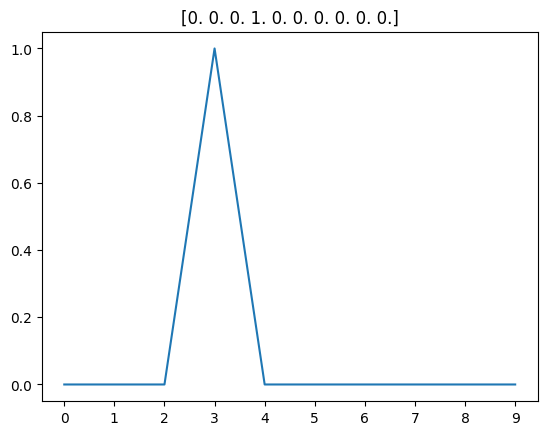

In [27]:
plt.title(y_train[9])
plt.plot(y_train[9])
plt.xticks(range(10));

#Designing Neural Network Architecture

In [28]:
# fix random seed for reproducibility
seed = 43
np.random.seed(seed)

In [31]:
!pip install -q keras-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 6.9 MB/s eta 0:00:00


In [33]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "jax"

# Note that keras_core should only be imported after the backend
# has been configured. The backend cannot be changed once the
# package is imported.
import keras_core as keras

Using JAX backend.


In [34]:
from tensorflow.keras import layers

In [37]:
from keras.models import  Sequential
from keras.layers import  Lambda , Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Convolution2D , MaxPooling2D

In [38]:
model= Sequential()
model.add(Lambda(standardize,input_shape=(28,28,1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
print("input shape ",model.input_shape)
print("output shape ",model.output_shape)

input shape  (None, 28, 28, 1)
output shape  (None, 10)


In [40]:
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=0.001),
 loss='categorical_crossentropy',
 metrics=['accuracy'])

In [41]:
from keras.preprocessing import image
gen = image.ImageDataGenerator()

In [42]:
from sklearn.model_selection import train_test_split
X = X_train
y = y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches=gen.flow(X_val, y_val, batch_size=64)

In [44]:
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3,
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/3


<ipython-input-44-43ce9e55712b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3,


  588/37800 [..............................] - ETA: 3:38 - loss: 0.4419 - accuracy: 0.8675

37800/37800 [==============================] - 5s 110us/step - loss: 0.4409 - accuracy: 0.8678 - val_loss: 0.3342 - val_accuracy: 0.9010
